Duplicates: 1186
After dedup: 213764
Age 0 count: 3912
After age filter: 209852
Survival distribution:
 survived
1    206365
0      3487
Name: count, dtype: int64

=== Q1: Feature Importances ===
Top 10 factors affecting survivability:
 อายุ                      0.327995
hour                      0.231688
day_of_month              0.100451
การดื่มสุรา_ไม่ทราบ       0.043884
sex                       0.021428
ถนนที่เกิดเหตุ_ทางหลวง    0.019499
month                     0.018426
รถผู้บาดเจ็บ_ปิคอัพ       0.014926
สถานะ_ผู้ชับขี่           0.014373
รถคู่กรณี_ปิคอัพ          0.014034
dtype: float64

=== Q2: Helmet Effect ===


/Users/pupipatsingkhorn/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


helmet ATE: 0.0025
Refute: Use a Placebo Treatment
Estimated effect:0.002532944948441239
New effect:-0.00017250688227805073
p value:0.88

Refute: Add a random common cause
Estimated effect:0.002532944948441239
New effect:0.002532944948441239
p value:1.0

Naive diff-in-means: 0.0076

=== Q3: Seatbelt Effect ===
seatbelt ATE: 0.0196
Refute: Use a Placebo Treatment
Estimated effect:0.019595732734418867
New effect:-0.0001993262212240316
p value:1.0

Refute: Add a random common cause
Estimated effect:0.019595732734418867
New effect:0.01959573273441887
p value:1.0

Naive diff-in-means: 0.0199

=== Q4: Alcohol Effect ===


/Users/pupipatsingkhorn/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


alcohol ATE: 0.0064
Refute: Use a Placebo Treatment
Estimated effect:0.006412298023228655
New effect:5.520521476951851e-06
p value:0.96

Refute: Add a random common cause
Estimated effect:0.006412298023228655
New effect:0.006412298023228652
p value:1.0

Naive diff-in-means: 0.0042

=== Q5: Hospital Effect ===
Hospital survival difference std: 0.05377733820168814

=== Q6: Hourly Survival ===


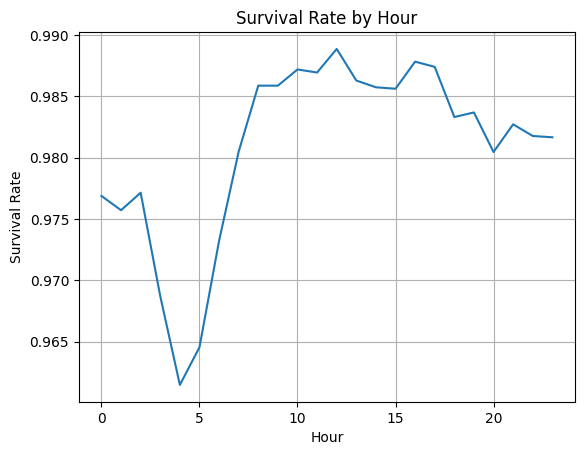

In [2]:
# improved_analysis_pipeline.py
# References:
# pandas: https://pandas.pydata.org/docs/
# numpy: https://numpy.org/doc/
# scikit-learn: https://scikit-learn.org/stable/modules/classes.html
# dowhy: https://microsoft.github.io/dowhy/
# matplotlib: https://matplotlib.org/stable/api/pyplot_api.html

import os
import re

import numpy as np  # numpy documentation: https://numpy.org/doc/
import pandas as pd  # pandas documentation: https://pandas.pydata.org/docs/
import matplotlib.pyplot as plt  # matplotlib documentation: https://matplotlib.org/stable/api/pyplot_api.html

from sklearn.ensemble import RandomForestClassifier  # scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.linear_model import LogisticRegression  # scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.preprocessing import StandardScaler
from dowhy import CausalModel  # dowhy: https://microsoft.github.io/dowhy/


def load_data(path: str) -> pd.DataFrame:
    """Load raw Excel data."""
    return pd.read_excel(path)


def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Perform data cleaning:
    1. Remove duplicates.
    2. Filter valid ages.
    3. Create binary survival label.
    4. Extract month and hour correctly.
    5. Encode sex.
    6. Drop unneeded columns.
    """
    df = df.copy()
    # 1. Duplicates
    print(f"Duplicates: {df.duplicated().sum()}")
    df = df.drop_duplicates()
    print(f"After dedup: {df.shape[0]}")
    
    # 2. Age validity
    print(f"Age 0 count: {(df['อายุ'] == 0).sum()}")
    df = df[df['อายุ'] > 0]
    print(f"After age filter: {df.shape[0]}")
    
    # 3. Survival label
    df['survived'] = (df['ผลการรักษา'] == 'ทุเลา/หาย').astype(int)
    print("Survival distribution:\n", df['survived'].value_counts())
    df = df.drop(columns=['ผลการรักษา'])
    
    # 4. Date/Time processing
    df = df.rename(columns={'วันที่เกิดเหตุ': 'day_of_month'})
    df = df[df['day_of_month'].between(1, 31)]
    # Map month for New Year period: days 29-31 -> Dec(12), days 1-4 -> Jan(1)
    df['month'] = df['day_of_month'].apply(lambda x: 12 if x >= 29 else (1 if x <= 4 else np.nan))
    df = df.dropna(subset=['month'])
    df['month'] = df['month'].astype(int)
    
    def extract_hour(s):
        if pd.isna(s) or 'ไม่ทราบ' in str(s):
            return np.nan
        cleaned = re.sub(r'[^0-9:]', '', str(s))
        if cleaned.startswith('24:'):
            cleaned = '00:' + cleaned[3:]
        try:
            return int(cleaned.split(':')[0])
        except ValueError:
            return np.nan
    
    df['hour'] = df['เวลาเกิดเหตุ'].apply(extract_hour)
    df = df.drop(columns=['เวลาเกิดเหตุ'])
    
    # 5. Gender encoding
    df['sex'] = df['เพศ'].map({'ชาย': 1, 'หญิง': 0})
    df = df.drop(columns=['เพศ'])
    
    # 6. Drop irrelevant columns
    df = df.drop(columns=['จังหวัด', 'ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ', 'ชื่อเทศกาล'], errors='ignore')
    return df


def feature_importance_rf(df: pd.DataFrame):
    """Compute and display top-5 feature importances via Random Forest."""
    feats = ['อายุ', 'sex', 'day_of_month', 'month', 'hour',
             'ถนนที่เกิดเหตุ', 'สถานะ', 'รถผู้บาดเจ็บ',
             'รถคู่กรณี', 'มาตรการ', 'การดื่มสุรา']
    sub = df[feats + ['survived']].dropna(subset=['hour'])
    sub = pd.get_dummies(sub, columns=[
        'ถนนที่เกิดเหตุ', 'สถานะ', 'รถผู้บาดเจ็บ',
        'รถคู่กรณี', 'มาตรการ', 'การดื่มสุรา'
    ], drop_first=True)
    X = sub.drop(columns=['survived'])
    y = sub['survived']
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    imp = pd.Series(model.feature_importances_, index=X.columns)
    print("Top 10 factors affecting survivability:\n", imp.sort_values(ascending=False).head(10))


def estimate_causal_effect(df: pd.DataFrame, treatment: str, outcome: str, confounders: list):
    """
    Estimate ATE with DoWhy (PSM) and run two refutation tests.
    """
    data = df.dropna(subset=[treatment, outcome] + confounders)
    model = CausalModel(
        data=data,
        treatment=treatment,
        outcome=outcome,
        common_causes=confounders
    )
    estimand = model.identify_effect()
    est = model.estimate_effect(estimand, method_name="backdoor.propensity_score_matching")
    print(f"{treatment} ATE: {est.value:.4f}")
    # Refutations
    print(model.refute_estimate(estimand, est, method_name="placebo_treatment_refuter"))
    print(model.refute_estimate(estimand, est, method_name="random_common_cause"))
    naive = data[data[treatment] == 1][outcome].mean() - data[data[treatment] == 0][outcome].mean()
    print(f"Naive diff-in-means: {naive:.4f}")


def hospital_effect(df: pd.DataFrame):
    """Assess hospital-level deviations from expected survival."""
    feats = ['อายุ', 'sex', 'ถนนที่เกิดเหตุ', 'สถานะ',
             'รถผู้บาดเจ็บ', 'รถคู่กรณี', 'มาตรการ', 'การดื่มสุรา']
    sub = df[feats + ['survived', 'รหัส รพ.']].dropna()
    sub_enc = pd.get_dummies(sub, columns=feats, drop_first=True)
    X = sub_enc.drop(columns=['survived', 'รหัส รพ.'])
    y = sub_enc['survived']
    X_scaled = StandardScaler().fit_transform(X)
    log = LogisticRegression(max_iter=5000, solver='liblinear').fit(X_scaled, y)
    sub['expected'] = log.predict_proba(X_scaled)[:, 1]
    rates = sub.groupby('รหัส รพ.').agg(
        observed=('survived', 'mean'),
        expected=('expected', 'mean')
    )
    rates['difference'] = rates['observed'] - rates['expected']
    print("Hospital survival difference std:", rates['difference'].std())


def plot_hourly_survival(df: pd.DataFrame):
    """Plot survival rate by hour of day."""
    hr = (
        df[df['hour'].notnull()]
        .assign(hour=lambda x: x['hour'].astype(int))
        .groupby('hour')['survived']
        .mean()
    )
    hr.plot(title='Survival Rate by Hour', xlabel='Hour', ylabel='Survival Rate')
    plt.grid(True)
    plt.show()


def main():
    repo = os.path.dirname(os.getcwd())
    path = os.path.join(repo, 'final-project', 'data', 'raw.xlsx')
    df = load_data(path)
    df = clean_data(df)

    print("\n=== Q1: Feature Importances ===")
    feature_importance_rf(df)

    print("\n=== Q2: Helmet Effect ===")
    df_mc = df[df['รถผู้บาดเจ็บ'] == 'จักรยานยนต์'].copy()
    df_mc = df_mc[df_mc['มาตรการ'].notna()]
    df_mc['helmet'] = (df_mc['มาตรการ'] == 'ใส่หมวก').astype(int)
    df_mc_enc = pd.get_dummies(df_mc, columns=['ถนนที่เกิดเหตุ','การดื่มสุรา'], drop_first=True)
    conf = ['อายุ','sex'] + [c for c in df_mc_enc.columns if c.startswith(('ถนนที่เกิดเหตุ_','การดื่มสุรา_'))]
    estimate_causal_effect(df_mc_enc, 'helmet', 'survived', conf)

    print("\n=== Q3: Seatbelt Effect ===")
    car_types = ['รถเก๋ง/แท็กซี่', 'ปิคอัพ', 'รถตู้']
    df_car = df[df['รถผู้บาดเจ็บ'].isin(car_types)].copy()
    df_car = df_car[df_car['มาตรการ'].notna()]
    df_car['seatbelt'] = (df_car['มาตรการ'] == 'เข็มขัด').astype(int)
    df_car_enc = pd.get_dummies(df_car, columns=['ถนนที่เกิดเหตุ','การดื่มสุรา'], drop_first=True)
    conf_car = ['อายุ','sex'] + [c for c in df_car_enc.columns if c.startswith(('ถนนที่เกิดเหตุ_','การดื่มสุรา_'))]
    estimate_causal_effect(df_car_enc, 'seatbelt', 'survived', conf_car)

    print("\n=== Q4: Alcohol Effect ===")
    df_al = df[df['การดื่มสุรา'].notna()].copy()
    df_al['alcohol'] = (df_al['การดื่มสุรา'] == 'ดื่ม').astype(int)
    df_al_enc = pd.get_dummies(df_al, columns=['ถนนที่เกิดเหตุ','รถผู้บาดเจ็บ'], drop_first=True)
    conf_al = ['อายุ','sex'] + [c for c in df_al_enc.columns if c.startswith(('ถนนที่เกิดเหตุ_','รถผู้บาดเจ็บ_'))]
    estimate_causal_effect(df_al_enc, 'alcohol', 'survived', conf_al)

    print("\n=== Q5: Hospital Effect ===")
    hospital_effect(df)

    print("\n=== Q6: Hourly Survival ===")
    plot_hourly_survival(df)

if __name__ == '__main__':
    main()
